In [1]:
import os
import json
from recordtype import recordtype
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters
import pathlib

import dadrah.util.data_processing as dapr
import dadrah.selection.qr_workflow as qrwf

## params

In [2]:
params_t = recordtype('Parameters','qr_run_n, sig_sample_id, sig_xsec, poly_order, kfold_n')
params = params_t(qr_run_n = 42, sig_sample_id='GtoWW35naReco', sig_xsec=0, poly_order=5, kfold_n=5) 
quantiles = [0.3, 0.5, 0.7, 0.9]
out_qr_run_n = 43

## paths

In [3]:
def make_polys_json_path(qr_poly_run_n):
    envelope_dir = '/eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_'+str(qr_poly_run_n)+'/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope'
    polys_json_path = os.path.join(envelope_dir, 'polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json')
    pathlib.Path(envelope_dir).mkdir(parents=True, exist_ok=True)
    return polys_json_path

In [4]:
envelope_dir = '/eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_'+str(params.qr_run_n)+'/sig_GtoWW35naReco/xsec_'+str(params.sig_xsec)+'/loss_rk5_05/envelope'
polys_json_path = os.path.join(envelope_dir, 'polynomials_allQ_allFolds_'+ params.sig_sample_id + '_xsec_' + str(params.sig_xsec) + '.json')
fig_dir = '../fig/poly_analysis/'

## read envelope

In [5]:
bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

envelope_per_fold = {}
for k in range(params.kfold_n+1):
    envelope_json_path = os.path.join(envelope_dir, 'cut_stats_allQ_fold'+str(k+1)+'_'+ params.sig_sample_id + '_xsec_' + str(params.sig_xsec) + '.json')
    ff = open(envelope_json_path)
    envelope_per_fold['fold_{}'.format(k+1)] = json.load(ff)
    
x_shift = np.asarray(envelope_per_fold['fold_1'][str(quantiles[0])])[0,bin_idx]

In [6]:
x_shift

1200.0

# fitting functions

## generic fitting

In [7]:
def fit_poly_from_envelope(fit_fun, uncert_fun, degree, envelope, quantiles, *fit_args):
    
    bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

    fits = {}

    for qq in quantiles:

        qq_key = str(qq)
        env_qq = np.asarray(envelope[qq_key])

        x      = env_qq[:,bin_idx]
        y      = env_qq[:,mu_idx]
        uncert = uncert_fun(env_qq)        
        cc = fit_fun(degree, x, y, uncert, *fit_args)
        
        fits[qq] = np.poly1d(cc)

    return fits

In [8]:
def fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params, *fit_args):
    
    poly_fits_per_fold = {}
    
    for k in range(params.kfold_n+1):
        poly_fits = fit_poly_from_envelope(fit_fun, uncert_fun, degree, envelope_per_fold['fold_{}'.format(k+1)], quantiles, *fit_args)
        poly_fits_per_fold['fold_{}'.format(k+1)] = poly_fits
    
    return poly_fits_per_fold

## poly1d weighted fit

In [9]:
def fit_poly1d_coeff(degree, x, y, uncert):
    return np.polyfit(x, y, degree, w=1./uncert) # weights: inverse uncertainty

## curve fit

In [10]:
def poly_wrap(x, *p):
    return np.poly1d(p)(x)

In [11]:
def fit_curve_coeff(degree, x, y, uncert):
    cc, _ = sp.optimize.curve_fit(poly_wrap, x, y, np.ones(degree), sigma=uncert)
    return cc

## lm fit

In [12]:
def residual(params, x, y, uncert, x_shift):
    y_hat = np.poly1d(params)(x-x_shift) # shift first bin to zero & fix bias
    return (y - y_hat)/uncert

In [13]:
def fit_lm(degree, x, y, uncert, x_shift):
    
    params_lmfit = Parameters()
    for d in range(degree-1):
        params_lmfit.add('c'+str(d), value=1)
    # add fixed bias value
    params_lmfit.add('bias', value=y[0], vary=False)
    
    return minimize(residual, params_lmfit, args=(x, y, uncert, x_shift))

In [14]:
def fit_lm_coeff(degree, x, y, uncert, x_shift):
    
    out = fit_lm(degree, x, y, uncert, x_shift)
    
    return list(out.params.valuesdict().values())

## uncertainty functions

In [15]:
eps = 1e-6

In [16]:
def uncertainty_rmse(envelope, fix_point_n=0):
    sigma = envelope[:,rmse_idx]
    sigma[:fix_point_n] = eps
    return sigma

In [17]:
def uncertainty_yerr(envelope, fix_point_n=0):
    y = envelope[:,mu_idx]
    sigma = np.asarray([y-envelope[:,min_idx], envelope[:,max_idx]-y])
    sigma[:,:fix_point_n] = eps
    return sigma

In [18]:
def uncertainty_stddev(envelope, fix_point_n=0):
    sigma = (envelope[:,max_idx]-envelope[:,min_idx])/4
    sigma[:fix_point_n] = eps
    return sigma

In [19]:
def uncertainty_minmax(envelope, fix_point_n=0):
    sigma = envelope[:,max_idx]-envelope[:,min_idx]
    sigma[:fix_point_n] = eps
    return sigma

In [20]:
def uncertainty_updown(envelope, fix_point_n=0):
    y      = envelope[:,mu_idx]
    y_down = np.fabs(y-envelope[:,min_idx])
    y_up   = np.fabs(y-envelope[:,max_idx])
    sigma = y_down+y_up
    sigma[:fix_point_n] = eps
    return sigma

In [21]:
fp_n = 0
ee = np.asarray(envelope_per_fold['fold_1'][str(0.3)])
u_f = lambda e : uncertainty_updown(e,fp_n)
u = u_f(ee)

In [22]:
u

array([2.11942196e-03, 1.00493431e-03, 5.42998314e-04, 8.81195068e-04,
       1.19960308e-03, 7.94410706e-04, 6.81400299e-04, 7.21573830e-04,
       4.59790230e-04, 1.13761425e-03, 1.86276436e-03, 9.62853432e-04,
       8.77380371e-04, 1.31583214e-03, 1.91044807e-03, 2.30455399e-03,
       1.61290169e-03, 6.51359558e-04, 2.72440910e-03, 5.71560860e-03,
       7.20810890e-03, 4.15778160e-03, 2.92468071e-03, 1.00796223e-02,
       1.78816319e-02, 2.32577324e-02, 2.65705585e-02, 3.77049446e-02,
       4.98716831e-02, 6.46028519e-02, 9.05041695e-02, 1.27285480e-01,
       1.48059845e-01, 1.38564110e-01, 1.72985077e-01, 2.49495983e-01,
       3.74562263e-01, 5.05026340e-01, 6.40967369e-01, 7.82505512e-01])

In [23]:
fp_n = 3
u = u_f(ee)

In [24]:
u

array([1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 8.81195068e-04,
       1.19960308e-03, 7.94410706e-04, 6.81400299e-04, 7.21573830e-04,
       4.59790230e-04, 1.13761425e-03, 1.86276436e-03, 9.62853432e-04,
       8.77380371e-04, 1.31583214e-03, 1.91044807e-03, 2.30455399e-03,
       1.61290169e-03, 6.51359558e-04, 2.72440910e-03, 5.71560860e-03,
       7.20810890e-03, 4.15778160e-03, 2.92468071e-03, 1.00796223e-02,
       1.78816319e-02, 2.32577324e-02, 2.65705585e-02, 3.77049446e-02,
       4.98716831e-02, 6.46028519e-02, 9.05041695e-02, 1.27285480e-01,
       1.48059845e-01, 1.38564110e-01, 1.72985077e-01, 2.49495983e-01,
       3.74562263e-01, 5.05026340e-01, 6.40967369e-01, 7.82505512e-01])

## plotting functions

In [25]:
def plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, plot_name_suffix, x_shift=0):
    
    bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)
    
    for q in quantiles:
        
        fig, axs = plt.subplots(2, params.kfold_n+1, figsize=(30,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
        
        for k, ax, ax_ratio in zip(range(params.kfold_n+1), axs.flat, axs.flat[int(len(axs.flat)/2):]):
            
            envelope_q = np.asarray(envelope_per_fold['fold_{}'.format(k+1)][str(q)])
            poly_fit_q = poly_fits_per_fold['fold_{}'.format(k+1)][q]
            
            x = envelope_q[:,bin_idx]
            y = envelope_q[:,mu_idx]
            y_hat = poly_fit_q(x-x_shift)
            yerr = [y-envelope_q[:,min_idx], envelope_q[:,max_idx]-y]
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', ms=1.5, zorder=1)
            ax.plot(x, y_hat, c='r',lw=1, zorder=2)
            ax.set_title('fold {}'.format(k+1))
            
            ax_ratio.plot(x, (y-y_hat)/uncertainty_minmax(envelope_q), 'o', ms=1.7)
            ax_ratio.grid(True, which='major', axis='y')
            #ax_ratio.set_ylim([0.995,1.005])
        
        for ax in axs.flat:
            ax.label_outer()
        
        plt.suptitle('quantile {}'.format(q))
        plt.savefig(fig_dir+'poly_fit_q{}_{}.pdf'.format(int(q*100), plot_name_suffix))
        plt.show()

In [26]:
np.set_printoptions(precision=5, suppress=True)

# poly1d fits

In [27]:
def compute_poly1d_fits(degree, envelope_per_fold, quantiles, params):
    fit_fun = fit_poly1d_coeff
    uncert_fun = uncertainty_minmax
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

### degree = 5 

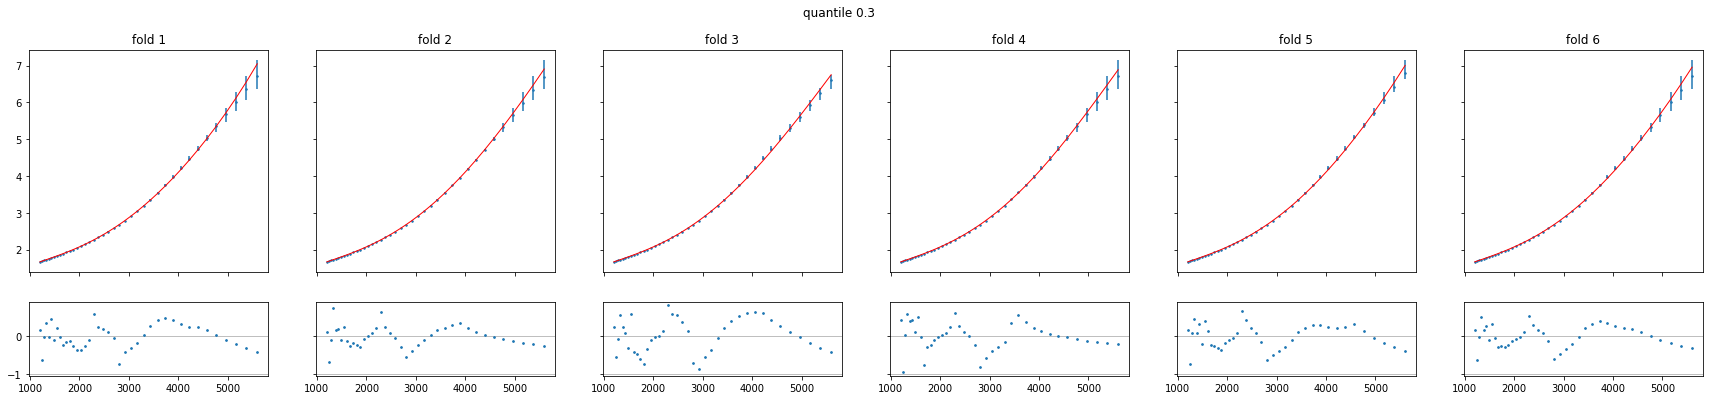

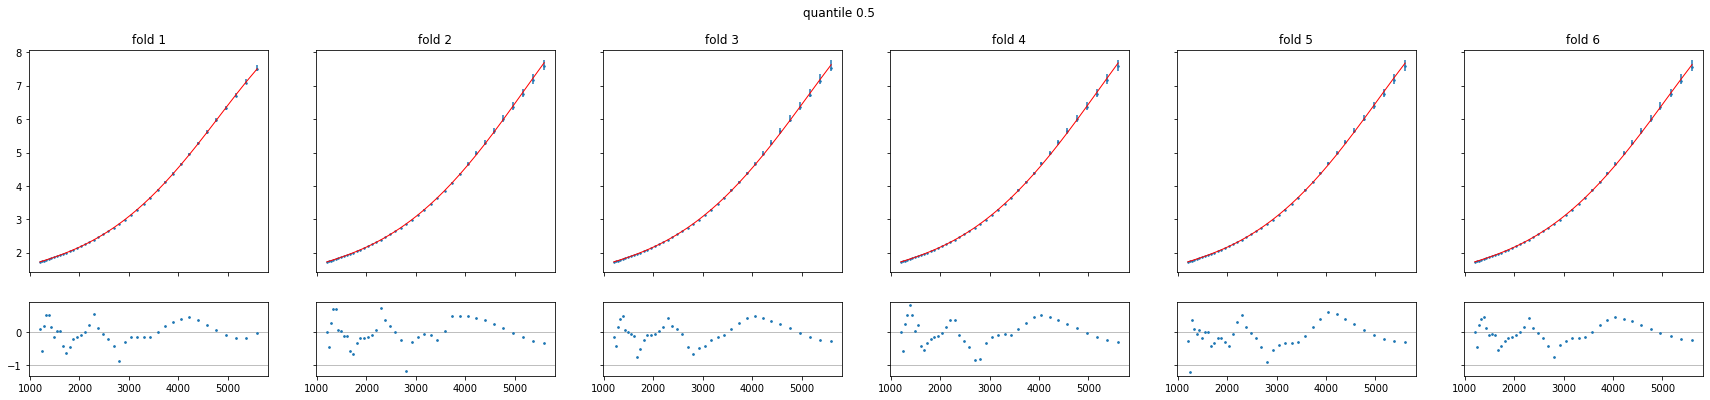

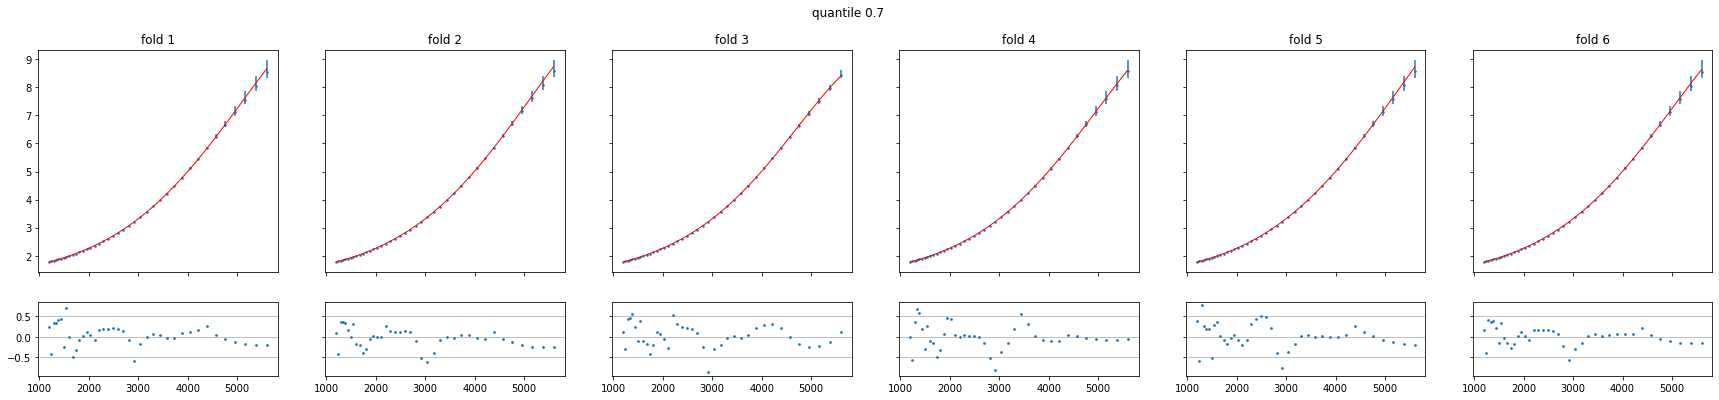

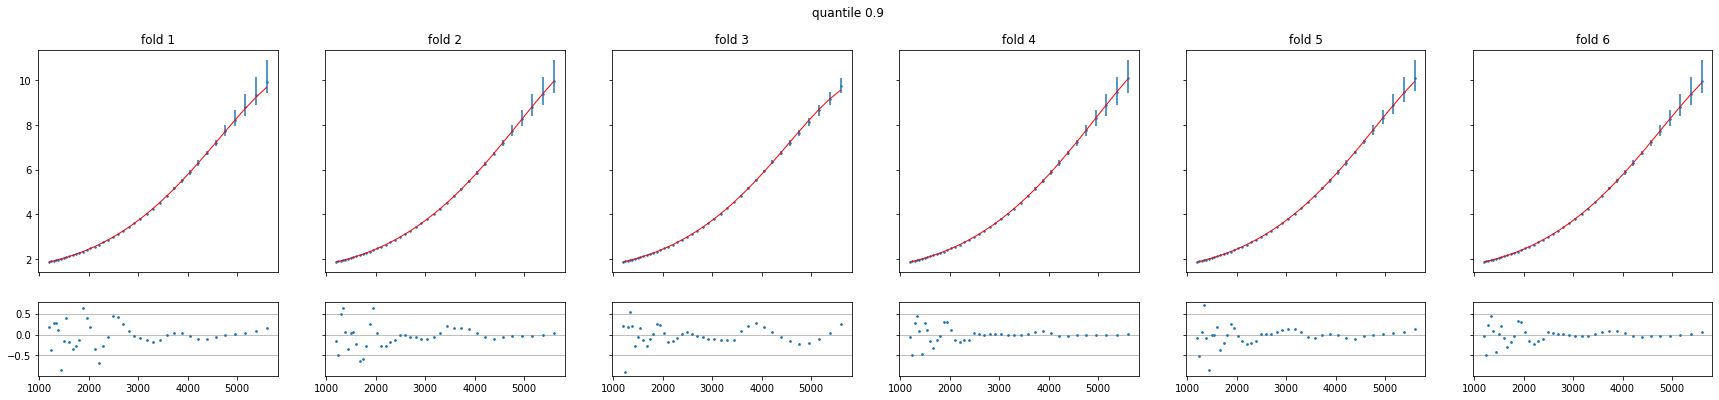

In [28]:
deg = 5
poly_fits_per_fold = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params) # per kfold -> per quantile
plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, 'np_polyfit_ord'+str(deg))

In [29]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), poly_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_43/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


### degree = 11

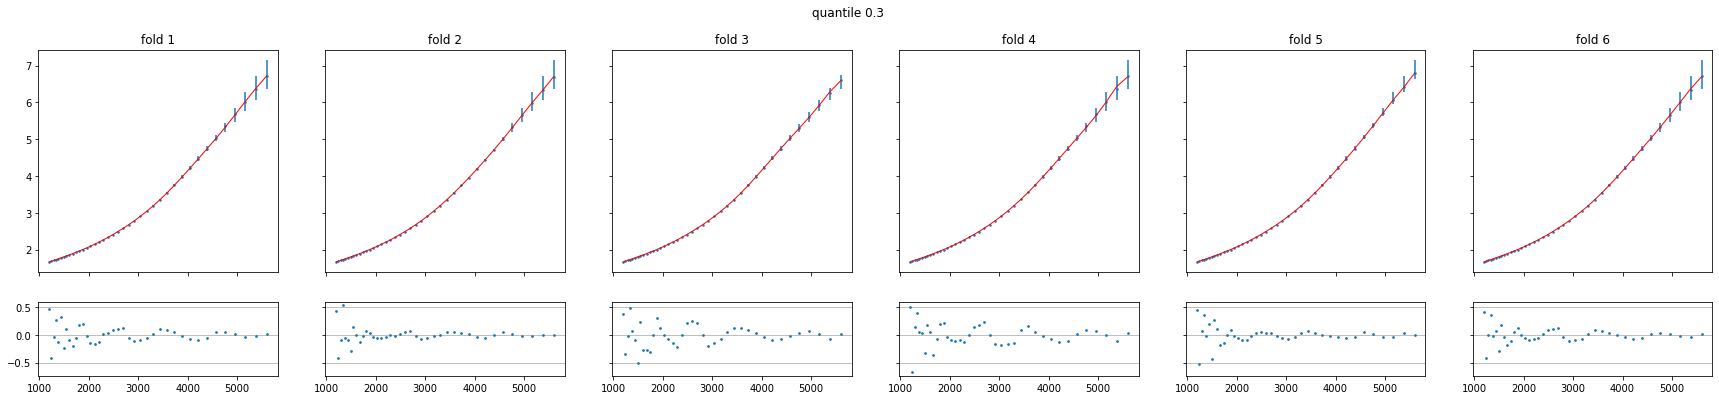

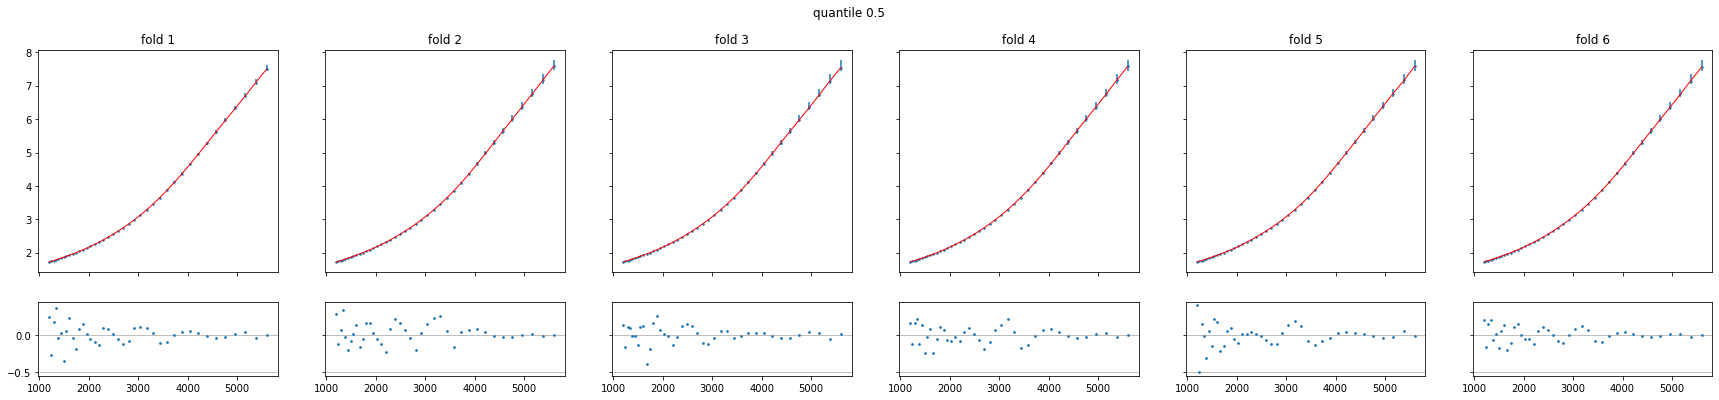

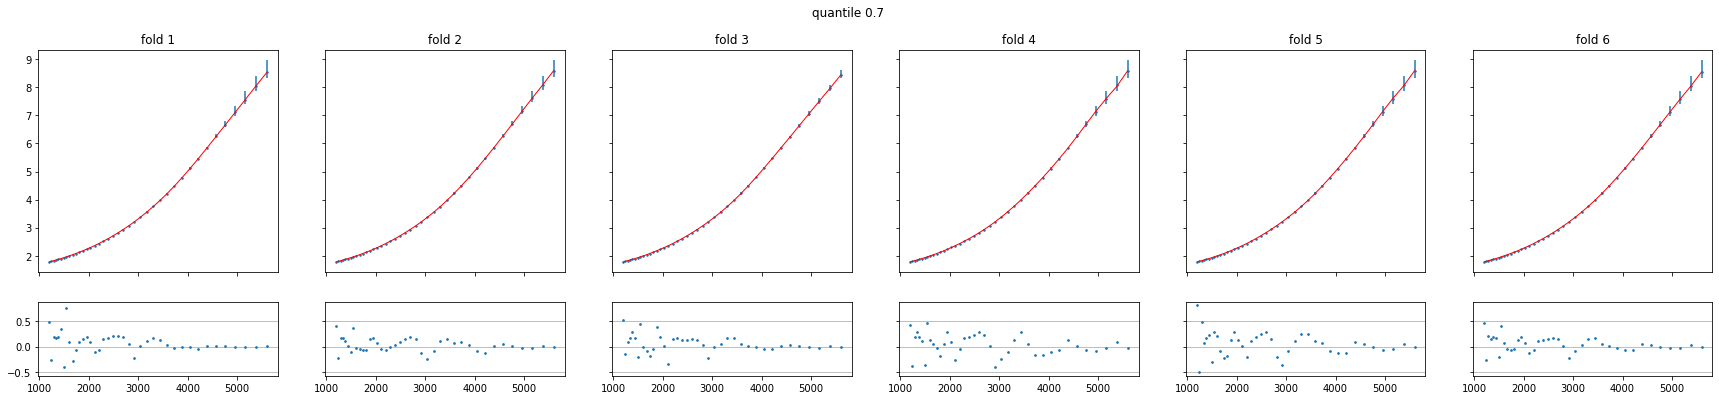

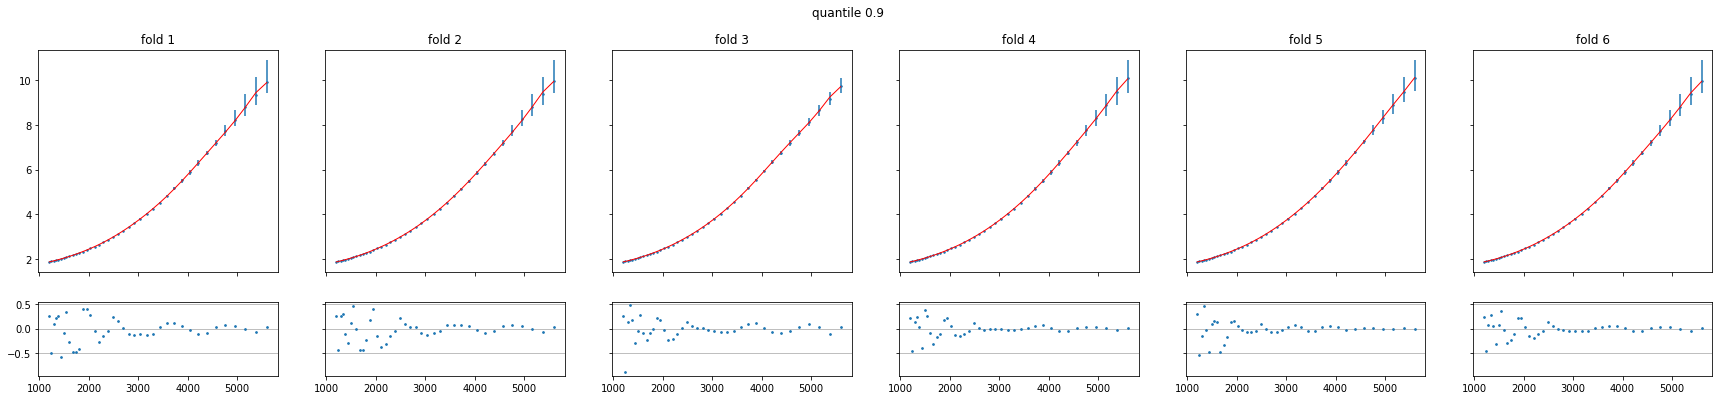

In [30]:
deg = 11
poly_fits_per_fold = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, 'np_polyfit_ord'+str(deg))

# curve_fit

In [31]:
def compute_curve_fits(degree, envelope_per_fold, quantiles, params, fix_point_n=3):
    fit_fun = fit_curve_coeff
    uncert_fun = lambda e: uncertainty_updown(e, fix_point_n)
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

## fixed points = 3

In [32]:
fix_point_n = 3

### degree = 7

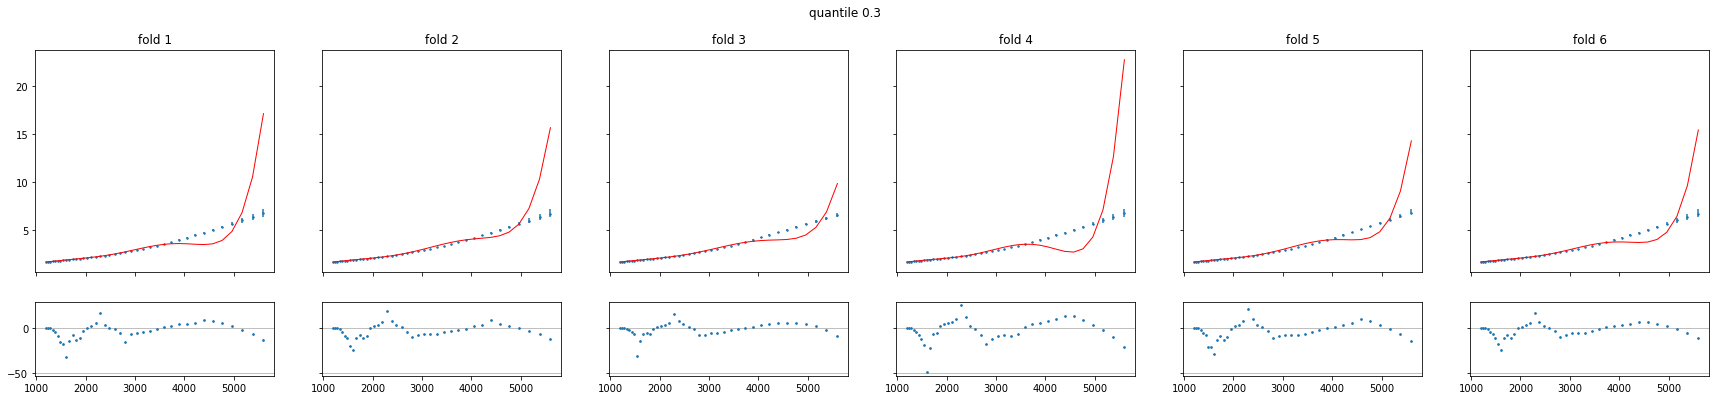

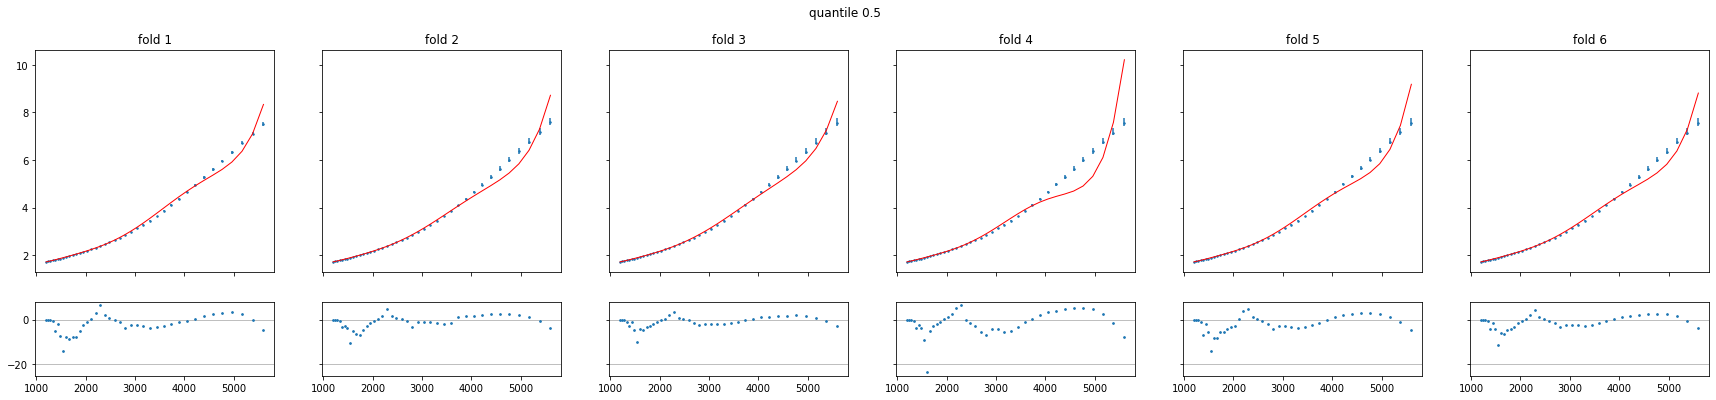

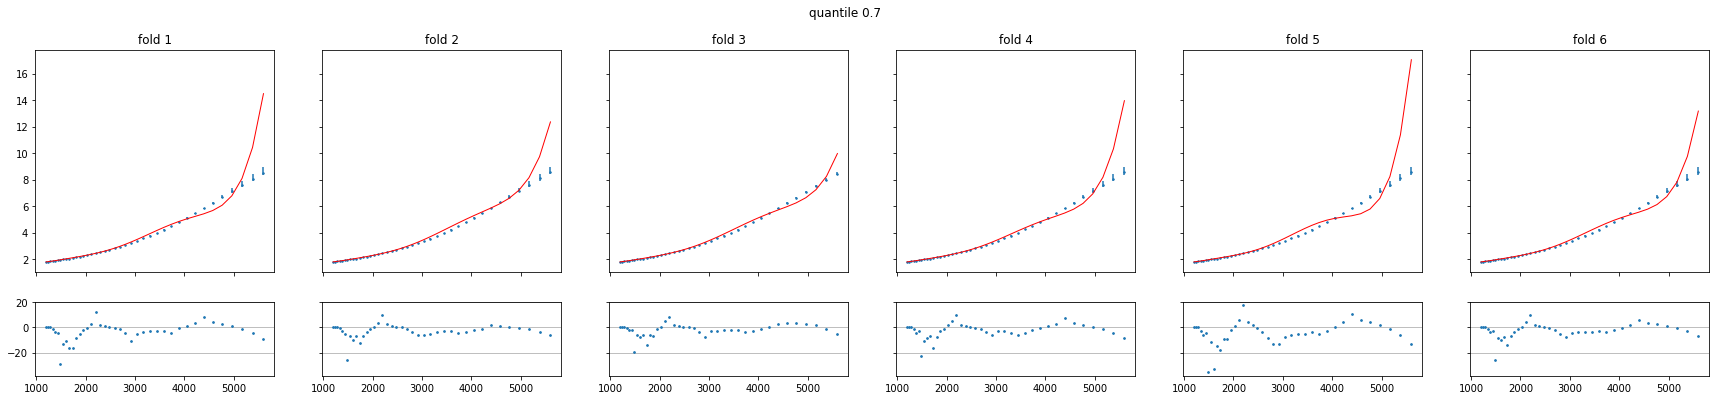

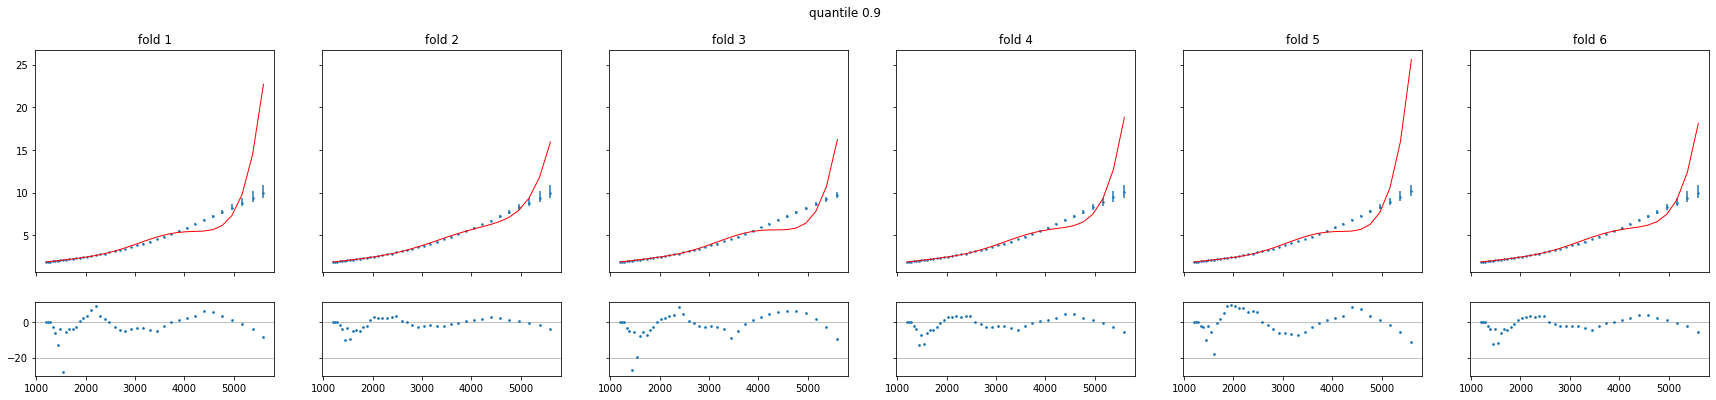

In [33]:
deg = 7
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params, fix_point_n)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg)+'_fixp_'+str(fix_point_n))

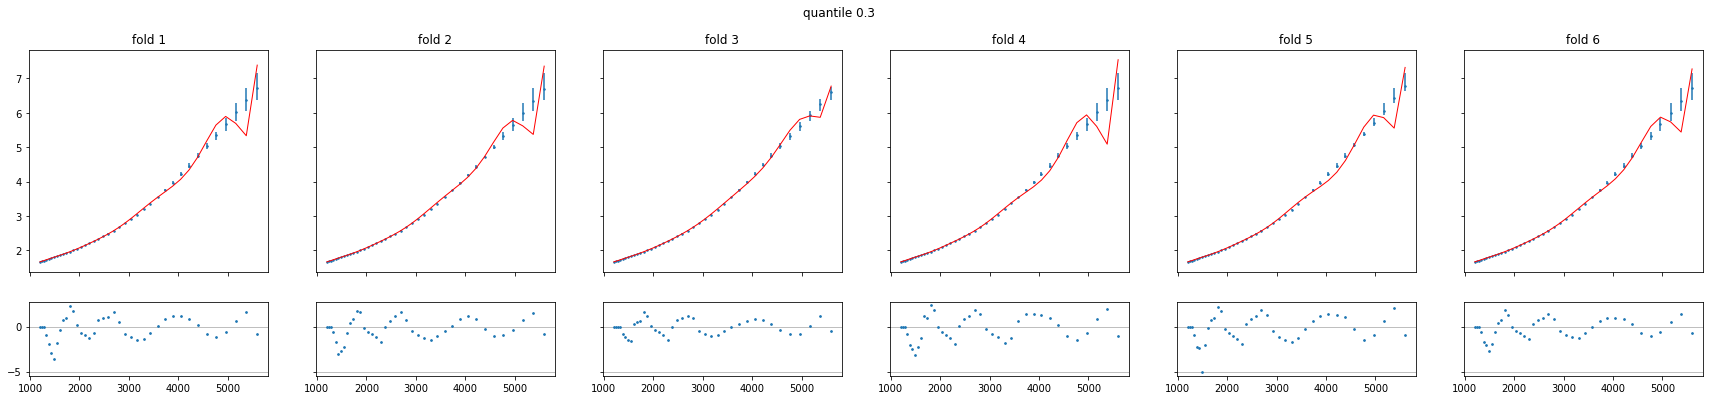

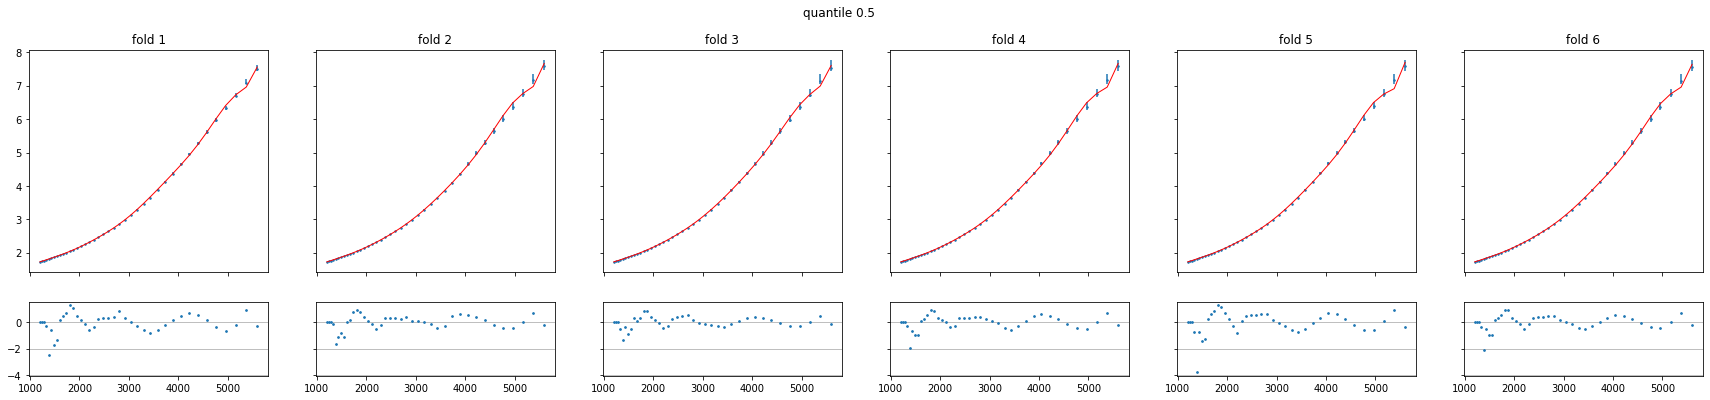

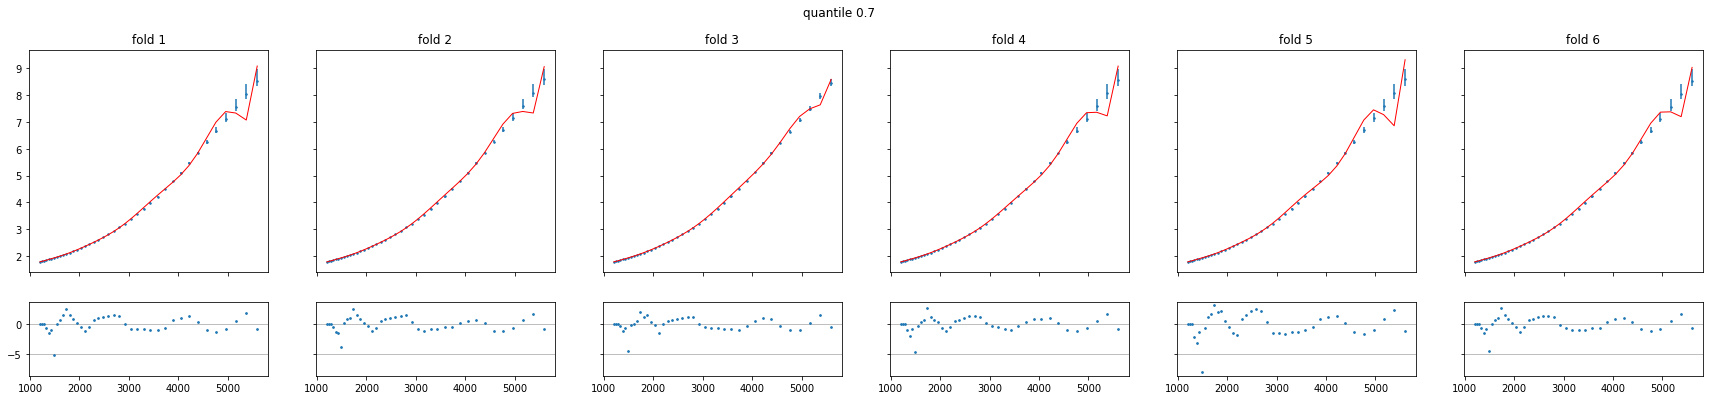

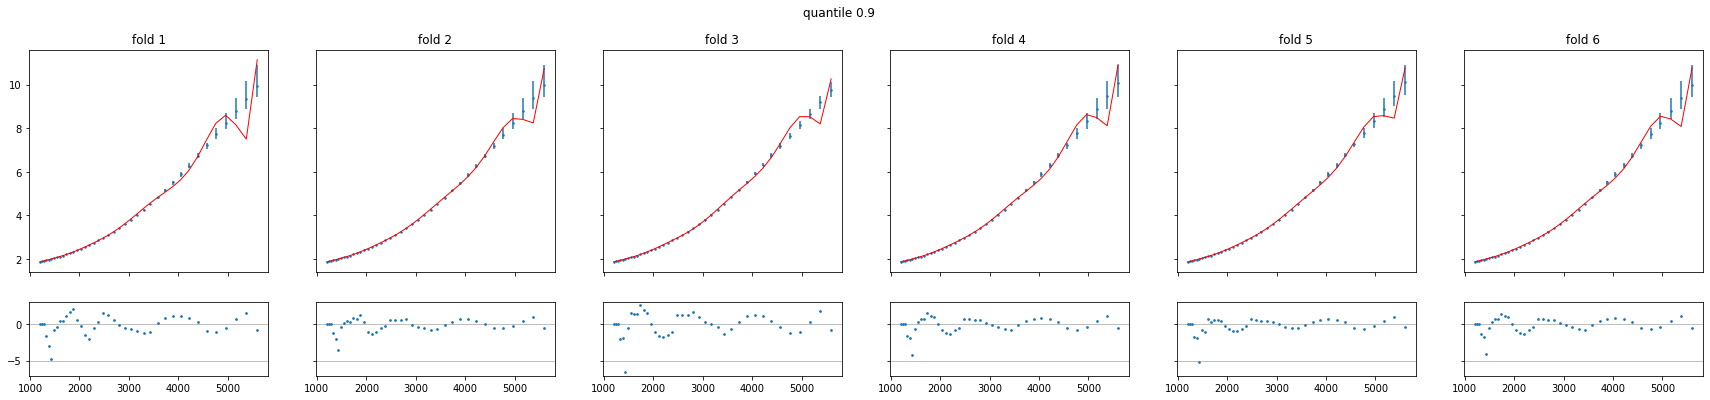

In [34]:
deg = 11
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params, fix_point_n)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg)+'_fixp_'+str(fix_point_n))

In [35]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n+1
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), curve_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_44/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


## lmfit

In [36]:
def compute_lm_fits(degree, envelope_per_fold, quantiles, params, x_shift):
    fit_fun = fit_lm_coeff
    uncert_fun = uncertainty_minmax #uncertainty_stddev #uncertainty_yerr #uncertainty_rmse
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params, x_shift)

### degree = 5

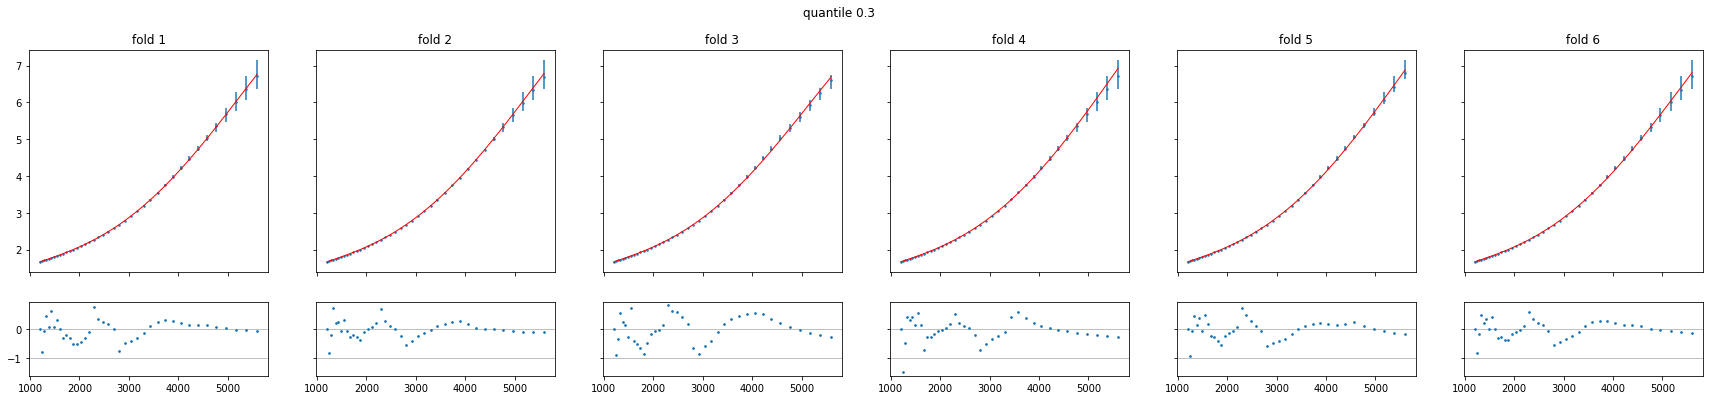

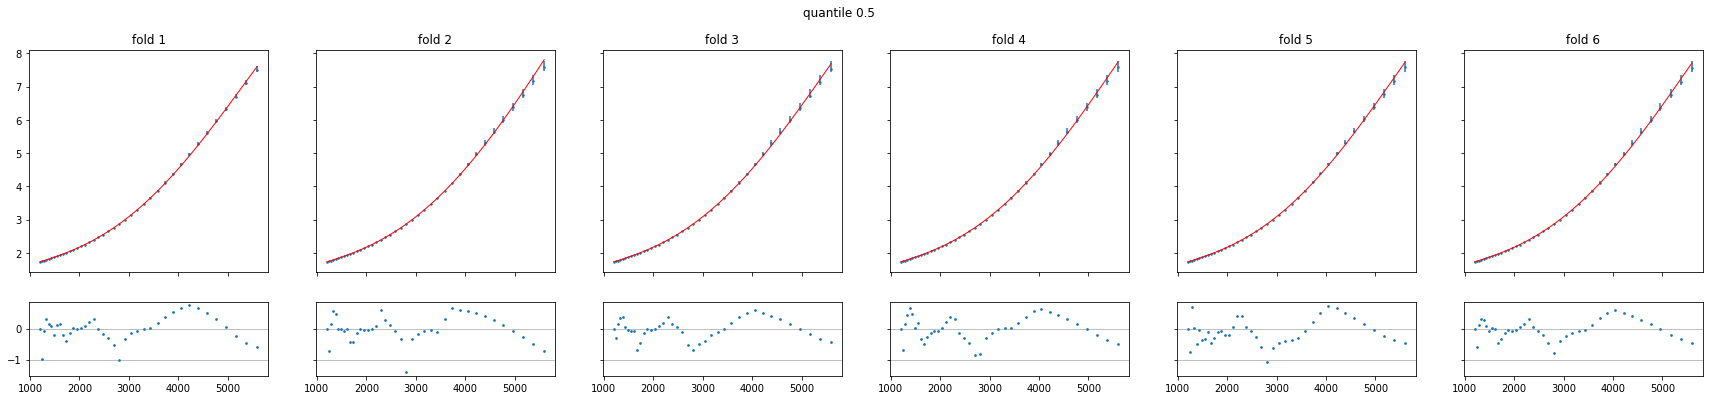

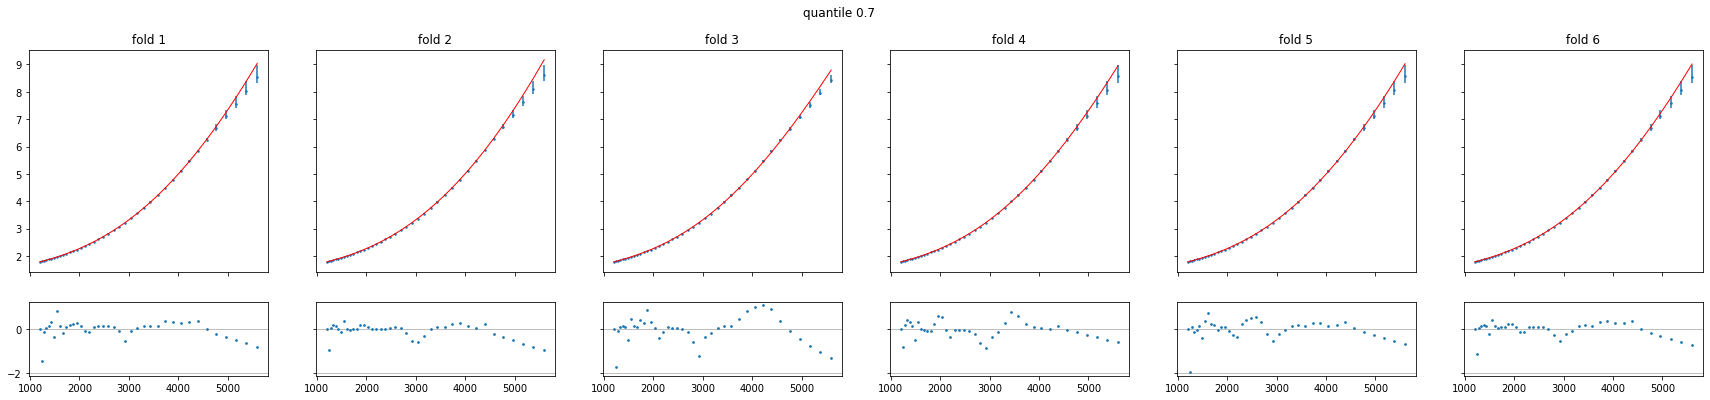

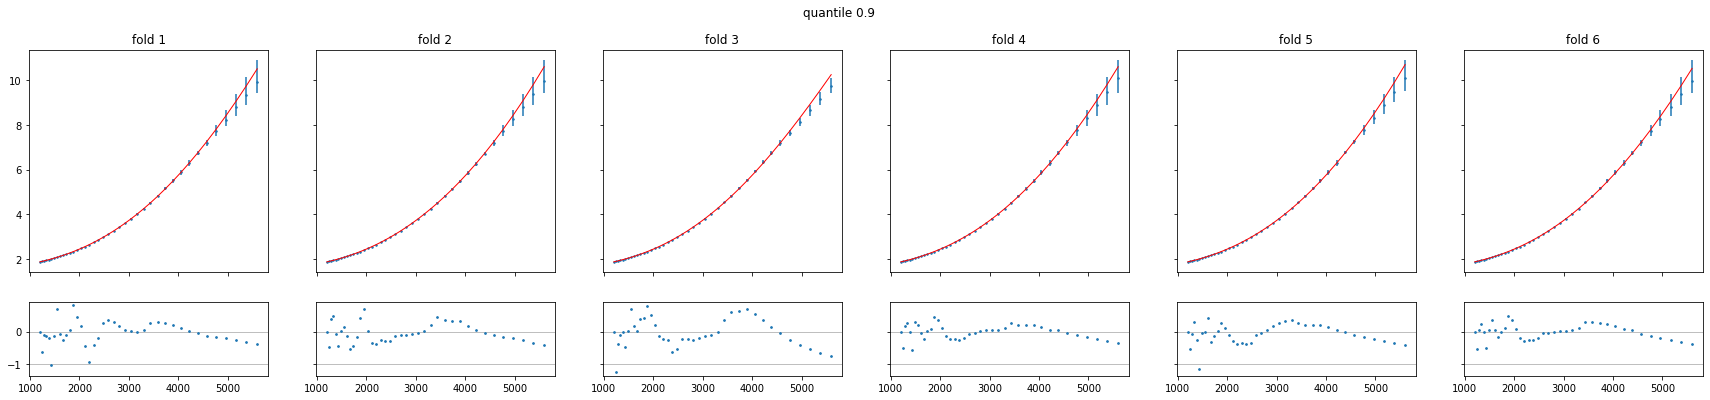

In [37]:
deg = 5
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params, x_shift)
plot_poly_fits(envelope_per_fold, lm_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg), x_shift)

In [38]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n+2
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), lm_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_45/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


### degree = 7

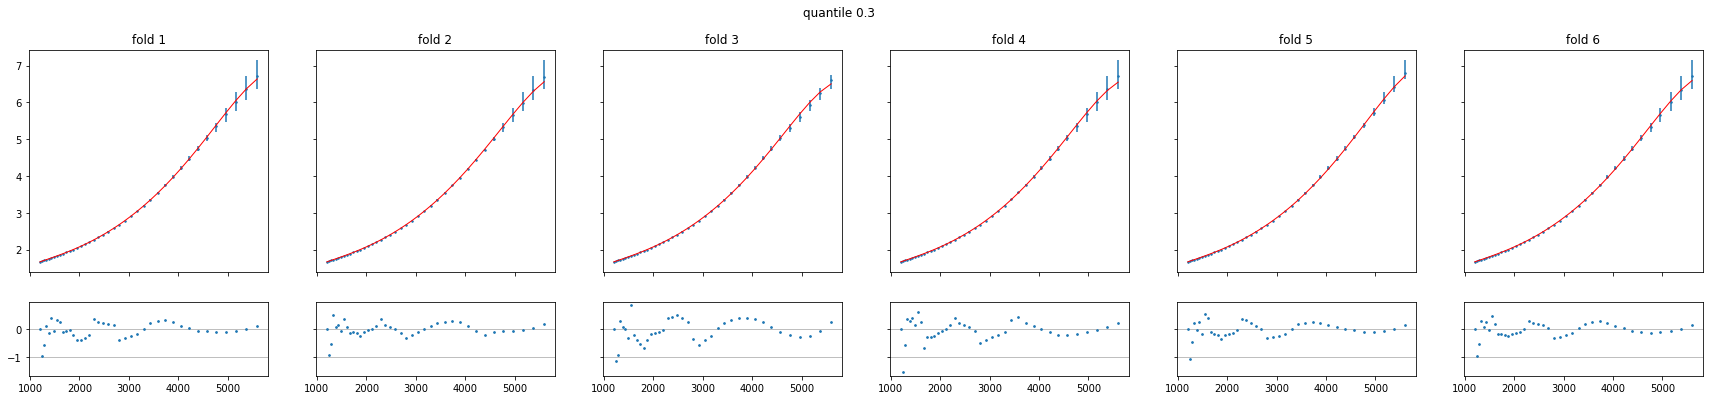

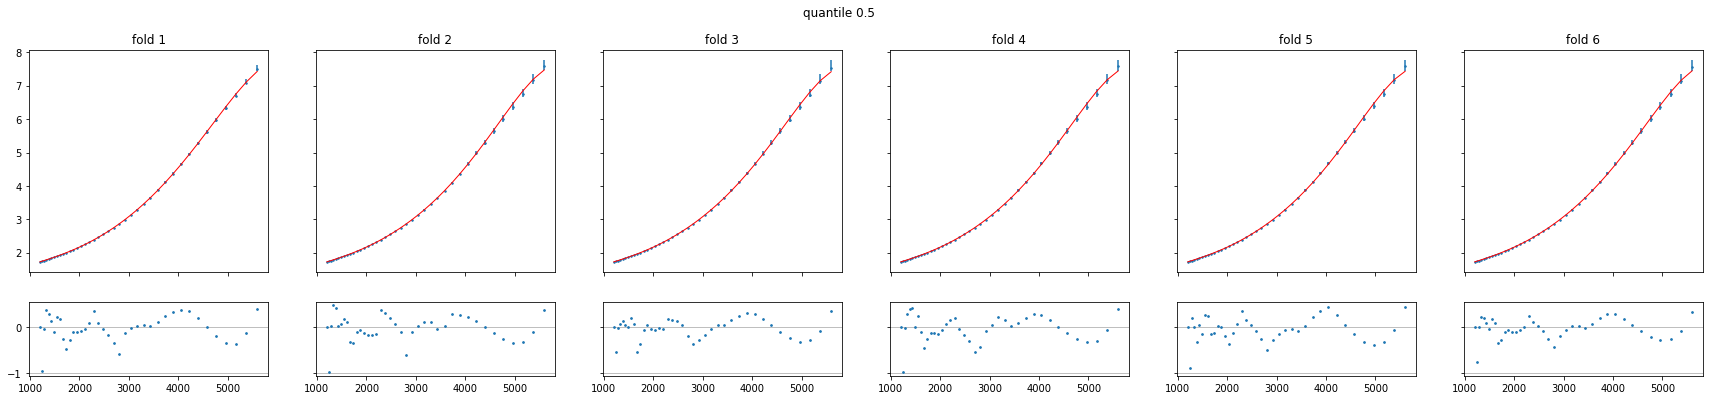

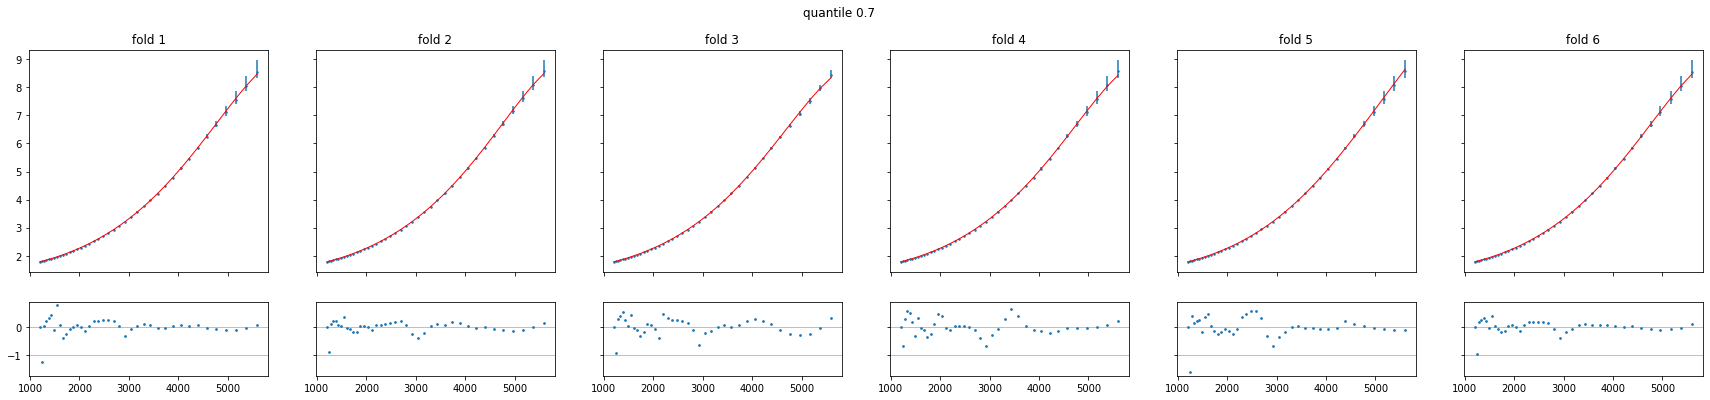

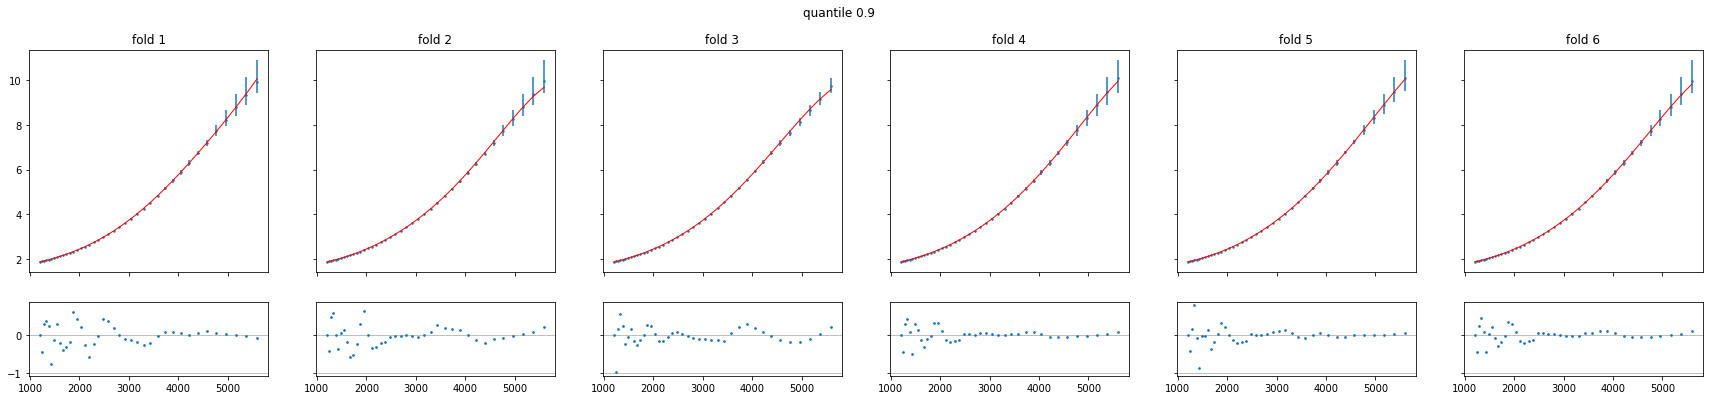

In [39]:
deg = 7
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params, x_shift)
plot_poly_fits(envelope_per_fold, lm_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg), x_shift)

### degree = 11

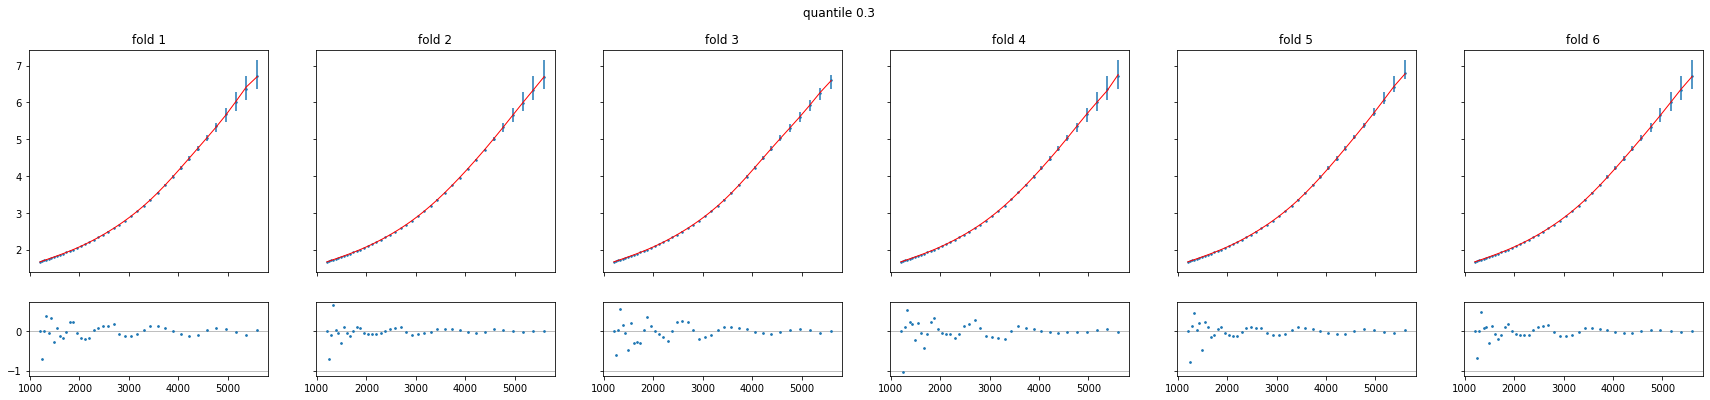

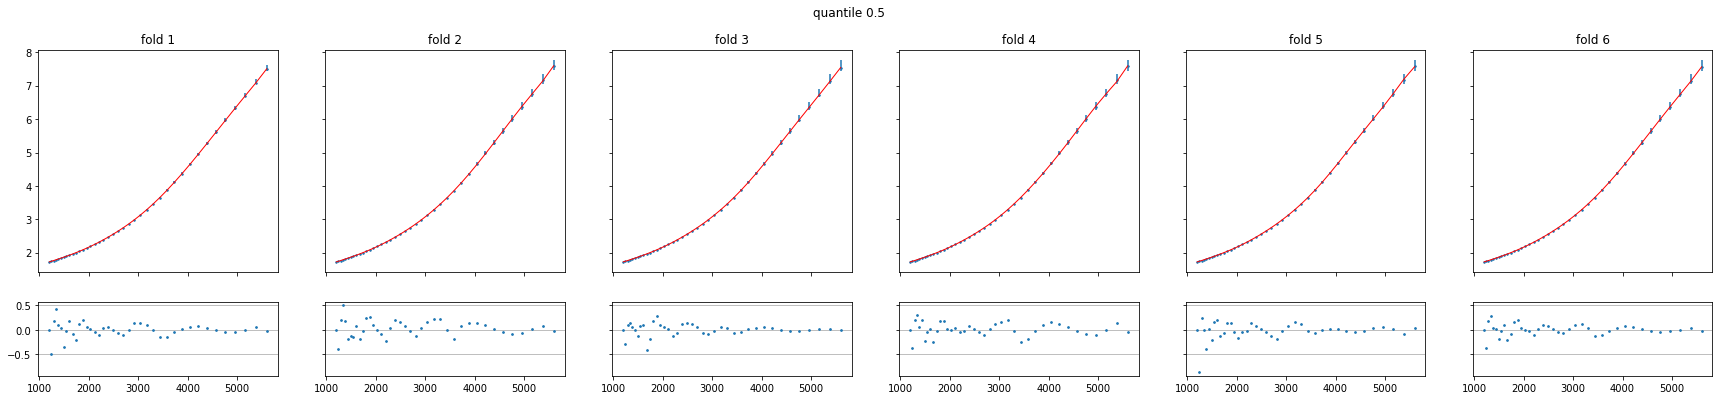

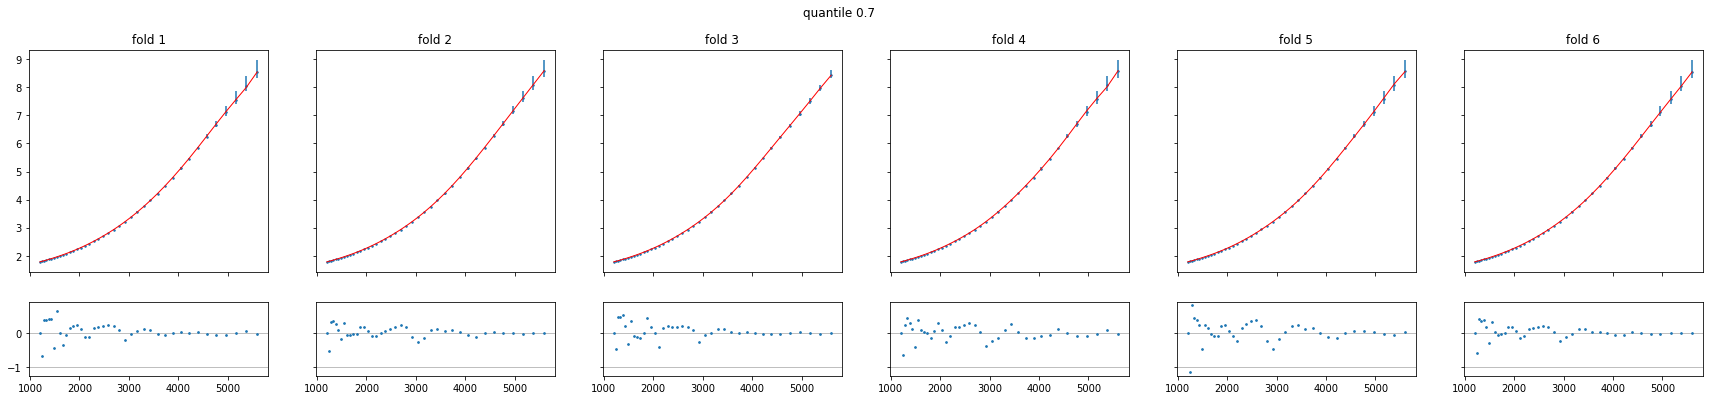

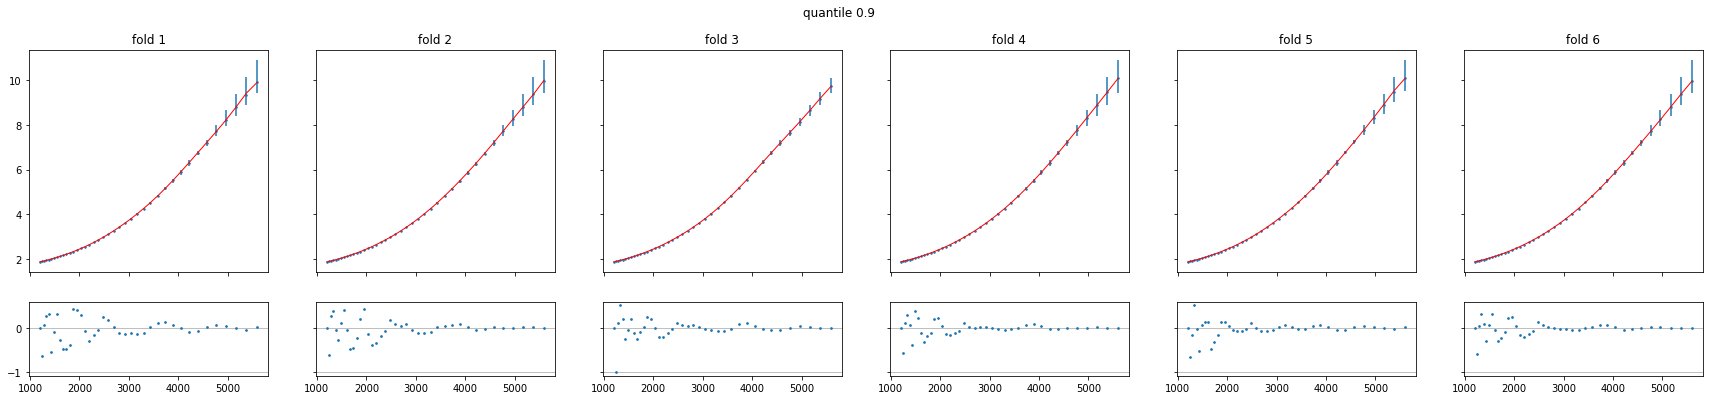

In [40]:
deg = 11
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params, x_shift)
plot_poly_fits(envelope_per_fold, lm_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg), x_shift)

In [41]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n+3
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), lm_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_46/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


# fit output analysis

In [42]:
np.set_printoptions(precision=5, suppress=True,formatter={'float': '{: 0.5f}'.format})
degrees = [5,7,11]

In [43]:
print('====  chi2 reduced  ====')
print('degrees:' + '\t'.join(str(d) for d in degrees))

for k in range(params.kfold_n+1):
    
    print('fold '+ str(k))    
    envelope = envelope_per_fold['fold_{}'.format(k+1)]

    for qq in quantiles:

        print('quantile {}'.format(qq))

        env_qq = np.asarray(envelope[str(qq)])

        x      = env_qq[:,bin_idx]
        y      = env_qq[:,mu_idx]
        uncert = uncertainty_minmax(env_qq)

        chisq = []
        for deg in degrees:
            out = fit_lm(deg, x, y, uncert)
            chisq.append(out.redchi)    
        print(np.asarray(chisq))

====  chi2 reduced  ====
degrees:5	7	11
fold 0
quantile 0.3


TypeError: fit_lm() missing 1 required positional argument: 'x_shift'

In [141]:
degree = 6

In [142]:
ee = np.asarray(envelope_per_fold['fold_1'][str(0.3)])
x = ee[:,bin_idx]
y = ee[:,mu_idx]
uncert = uncertainty_minmax(ee)

In [143]:
x

array([ 1200.00000,  1312.00000,  1425.00000,  1538.00000,  1651.00000,
        1764.00000,  1876.00000,  1989.00000,  2102.00000,  2215.00000,
        2328.00000,  2441.00000,  2553.00000,  2666.00000,  2779.00000,
        2892.00000,  3005.00000,  3117.00000,  3230.00000,  3343.00000,
        3456.00000,  3569.00000,  3682.00000,  3794.00000,  3907.00000,
        4020.00000,  4133.00000,  4246.00000,  4358.00000,  4471.00000,
        4584.00000,  4697.00000,  4810.00000,  4923.00000,  5035.00000,
        5148.00000,  5261.00000,  5374.00000,  5487.00000,  5600.00000])

In [144]:
y

array([ 1.66560,  1.71715,  1.77008,  1.82391,  1.87983,  1.93875,
        2.00022,  2.06556,  2.13523,  2.20990,  2.28929,  2.37346,
        2.46166,  2.55497,  2.65276,  2.75581,  2.86508,  2.98080,
        3.10563,  3.23972,  3.38193,  3.53002,  3.68323,  3.84037,
        4.00138,  4.16495,  4.33177,  4.50270,  4.67809,  4.86303,
        5.04938,  5.23601,  5.42287,  5.60989,  5.79539,  5.98263,
        6.16994,  6.35729,  6.54466,  6.73205])

In [145]:
uncert

array([ 0.00212,  0.00054,  0.00102,  0.00101,  0.00091,  0.00160,
        0.00087,  0.00160,  0.00229,  0.00142,  0.00155,  0.00424,
        0.00712,  0.00540,  0.00163,  0.00819,  0.01538,  0.02219,
        0.02466,  0.02821,  0.03935,  0.04911,  0.05941,  0.07162,
        0.09549,  0.12152,  0.14101,  0.14832,  0.13377,  0.15345,
        0.17481,  0.20722,  0.27878,  0.35051,  0.42176,  0.49375,
        0.56584,  0.63800,  0.71022,  0.78251])

In [146]:
x_shift

1200.0

In [147]:
cc = fit_lm_coeff(degree, x, y, uncert, x_shift)

TypeError: fit_lm_coeff() takes 4 positional arguments but 5 were given

In [ ]:
cc

In [132]:
pp = np.poly1d(cc)

In [133]:
y_hat = pp(x-x_shift)

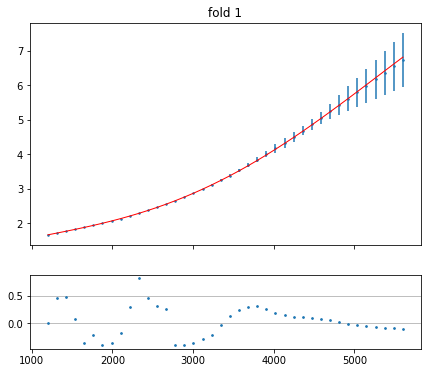

In [134]:
fig, axs = plt.subplots(2,1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax1, ax2 = axs.flat
ax1.errorbar(x, y, yerr=uncert, fmt='o', ms=1.5, zorder=1)
ax1.plot(x, y_hat, c='r',lw=1, zorder=2)
ax1.set_title('fold 1')
            
ax2.plot(x, (y-y_hat)/uncert, 'o', ms=1.7)
ax2.grid(True, which='major', axis='y')
#ax2.set_ylim([0.995,1.005])        

In [53]:
degree = 5
params_lmfit = Parameters()
for d in range(degree-1):
    params_lmfit.add('c'+str(d), value=1)
# add fixed bias value
params_lmfit.add('bias', value=y[0], vary=False)

out = minimize(residual, params_lmfit, args=(x, y, uncert))

In [54]:
out

In [55]:
out.redchi

0.08704224508717973

In [56]:
cc = list(out.params.valuesdict().values())

In [57]:
pp = np.poly1d(cc)

In [58]:
y_hat = pp(x-x_shift)

(0.995, 1.005)

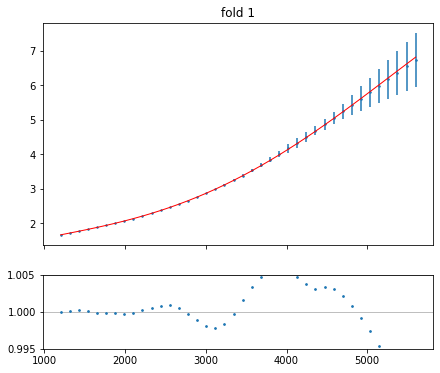

In [59]:
fig, axs = plt.subplots(2,1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax1, ax2 = axs.flat
ax1.errorbar(x, y, yerr=uncert, fmt='o', ms=1.5, zorder=1)
ax1.plot(x, y_hat, c='r',lw=1, zorder=2)
ax1.set_title('fold 1')
            
ax2.plot(x, y/y_hat, 'o', ms=1.7)
ax2.grid(True, which='major', axis='y')
ax2.set_ylim([0.995,1.005])        

In [60]:
pp(0)

1.6656025052070618

In [61]:
pp

poly1d([-0.00000,  0.00000,  0.00000,  0.00046,  1.66560])

In [62]:
cc

[-9.285508167584355e-15,
 7.484030206212058e-11,
 1.2579366416434521e-08,
 0.00045568609516556565,
 1.6656025052070618]

In [63]:
out.var_names

['c0', 'c1', 'c2', 'c3']

In [64]:
out.params['bias']

<Parameter 'bias', value=1.6656025052070618 (fixed), bounds=[-inf:inf]>

In [65]:
par = Parameters()
par.add('a', value=1)
par.add('b', value=2)
par.add('f', value=10, vary=False)

In [66]:
par

name,value,initial value,min,max,vary
a,1.00000000,1,-inf,inf,True
b,2.00000000,2,-inf,inf,True
f,10.0000000,10,-inf,inf,False


In [67]:
out = minimize(residual, par, args=(x, y, uncert))

In [68]:
out

In [69]:
input_dir_kfold = '/eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_'+str(params.kfold_n)+'fold_signalregion_parts'

In [70]:
from os import listdir

In [71]:
listdir(input_dir_kfold).sort()

In [72]:
files = listdir(input_dir_kfold)

In [73]:
print('reading ' + ' '.join(files))

reading qcd_sqrtshatTeV_13TeV_PU40_NEW_fold1.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold2.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold3.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold4.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold5.h5


In [77]:
def foo(a,*b):
    print('a',a)
    print('b',*b)

In [78]:
def bar(c, *d):
    print('call no star')
    foo(c,d)
    print('call star')
    foo(c,*d)

In [79]:
bar(10,100,1000)

call no star
a 10
b (100, 1000)
call star
a 10
b 100 1000


In [80]:
bar(10,3)

call no star
a 10
b (3,)
call star
a 10
b 3
